<a href="https://colab.research.google.com/github/biaferre/bioinspirada/blob/main/VRP_ProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VRP - Projeto final | Computação Bioinspirada 2025.1
*Grupo: Beatriz Férre, Danilo Lima, David Oscar, Luisa Leiria*

> Tema: Otimização do trajeto de coleta de lixo em bairros através do roteamento de veículos (VRP simplificado) em uma malha urbana simulada.

> Objetivo: Aplicar e comparar Algoritmo Genético, Particle Swarm Optimization, Dragonfly Algorithm, Ant Colony Optimization e Estratégia Evolutiva.

## 🛠️ Setup

### Imports

In [ ]:
import numpy as np
import random
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

### 🗺️ Simulador de Mapa

In [ ]:
def gerar_matriz_distancias(N=10, seed=42):
    np.random.seed(seed)
    matriz = np.random.randint(1, 101, size=(N, N))
    np.fill_diagonal(matriz, 0)
    matriz = (matriz + matriz.T) // 2  # tornar simétrica
    return matriz

def salvar_como_csv(matriz, nome_arquivo='instancia.csv'):
    df = pd.DataFrame(matriz)
    df.to_csv(nome_arquivo, index=False)
    print(f'Matriz salva em {nome_arquivo}')

def salvar_como_json(matriz, nome_arquivo='instancia.json'):
    instancia = {
        "numero_pontos": len(matriz),
        "distancias": matriz.tolist()
    }
    with open(nome_arquivo, 'w') as f:
        json.dump(instancia, f, indent=4)
    print(f'Matriz salva em {nome_arquivo}')

def estimar_limite_teorico(matriz):
    N = len(matriz)
    menores = np.sort(matriz[~np.eye(N, dtype=bool)])[:N]
    return int(np.sum(menores))

In [ ]:
N = 10
dist_matrix = gerar_matriz_distancias(N)

print("Matriz de distâncias:")
print(dist_matrix)

limite_teorico = estimar_limite_teorico(dist_matrix)
print(f"Limite teórico estimado (soma das menores distâncias): {limite_teorico}")

salvar_como_csv(dist_matrix, 'grafo_instancia.csv')
salvar_como_json(dist_matrix, 'grafo_instancia.json')

Matriz de distâncias:
[[ 0 90  8 81 61 19 87 68 82 73]
 [90  0 44 31 36 28 31 46 37 58]
 [ 8 44  0 31 44 82 64 12 61 68]
 [81 31 31  0 62 70 29 34 68 54]
 [61 36 44 62  0 32  7 37 67 39]
 [19 28 82 70 32  0 68 28 51 84]
 [87 31 64 29  7 68  0 66 47 58]
 [68 46 12 34 37 28 66  0 79 50]
 [82 37 61 68 67 51 47 79  0 34]
 [73 58 68 54 39 84 58 50 34  0]]
Limite teórico estimado (soma das menores distâncias): 148
Matriz salva em grafo_instancia.csv
Matriz salva em grafo_instancia.json


## 🧬 Algoritmo Genético

In [ ]:
POP_SIZE= 1000
NUM_GENERATIONS = 500
TOURNAMENT_K = 3
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.5
ELITISM = 2

In [ ]:
#cada individuo tem uma rota que é uma permutacao dos numeros de 0 ate n-1

def criar_individuo(n):
  individuo = np.random.permutation(n)
  return individuo

In [ ]:
#analisando o fitness (custo da rota) quanto menor o fitness melhor

def fitness(individuo, dist_matrix):
    """
    Calcula o custo total de um tour no TSP.

    Parâmetros:
    - individuo: lista/array com valores que representam a ordem das cidades
    - dist_matrix: matriz de distâncias entre as cidades

    Retorna:
    - custo: custo total do tour (menor é melhor)
    """
    # Converte valores contínuos para índices válidos de cidades
    n_cities = len(dist_matrix)

    # Se individuo já contém índices inteiros válidos, usa diretamente
    if all(isinstance(x, (int, np.integer)) and 0 <= x < n_cities for x in individuo):
        tour = individuo
    else:
        # Converte valores contínuos para uma permutação válida de cidades
        # Método 1: Ordenação por valor (mais simples)
        tour = np.argsort(individuo).astype(int)

    custo = 0
    for i in range(len(tour)):
        custo = custo + dist_matrix[tour[i-1], tour[i]]
    return custo


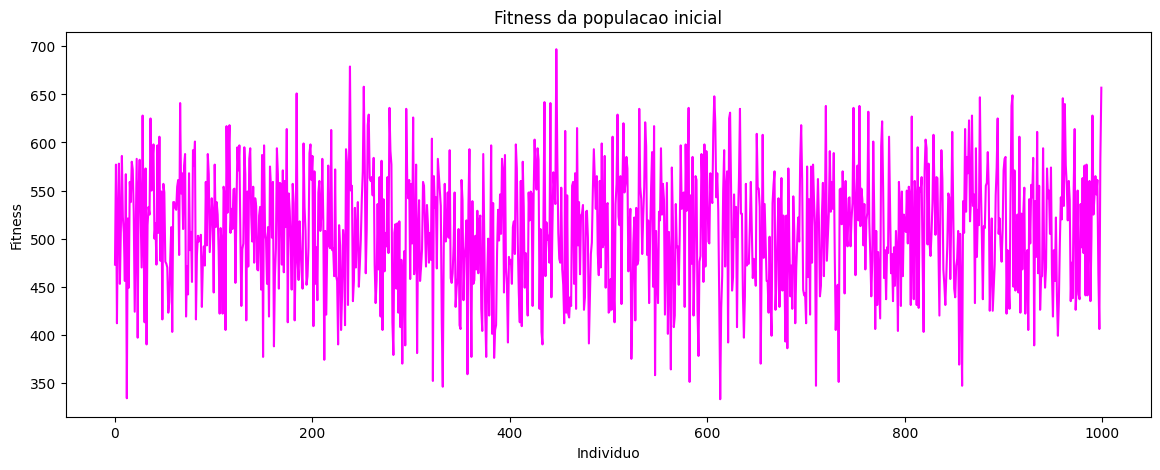

In [ ]:
#associando cada individuo ao seu fitness
#population = (rota, custo) = (genes, fitness)
population = []
for _ in range(POP_SIZE):
    ind = criar_individuo(N)
    population.append((ind, int(fitness(ind, dist_matrix))))


#plotando grafico do fitness da populacao inical
plt.figure(figsize=(14,5))
plt.plot([individuo[1] for individuo in population], color='magenta')
plt.xlabel('Individuo')
plt.ylabel('Fitness')
plt.title('Fitness da populacao inicial')
plt.show()

In [ ]:
# Combinando os indíviudos
# Código para a recombinação

def recombinacao (pai, mae):
  #pegando so o gene
  genPai, _ = pai
  genMae, _ = mae
  permPai = genPai.copy()
  permMae = genMae.copy()
  divisao = random.randint(1, N-1) #pos da divisao

  def laco(pai, mae, divisao):
    j=0
    i= divisao + 1
    vet = np.full(N-(divisao),0)
    while True:
      element = mae[i%N]
      if element not in pai[:divisao]:
        vet[j] = element
        j+=1
      i+=1
      if j == N-divisao:
        break
    return vet

  if random.random() < CROSSOVER_RATE:
    filho1 = np.concatenate((permPai[:divisao], laco(permPai,permMae,divisao)))
    filho2 = np.concatenate((permMae[:divisao], laco(permMae,permPai,divisao)))

  else:
    filho1 = permPai
    filho2 = permMae

  return filho1, filho2

In [ ]:
def mutacao (individuo):
  indMutado = individuo.copy()

  if random.random() < MUTATION_RATE:
    i, j = random.sample(range(len(indMutado)), 2)
    indMutado[i], indMutado[j] = indMutado[j], indMutado[i]

  return indMutado

In [ ]:
def criacaoPares (populacao):
  if len(populacao) % 2 != 0:
        populacao = populacao[:-1]  # remove o último se for ímpar
  return [(populacao[i], populacao[i+1]) for i in range(0, len(populacao), 2)]


In [ ]:
def gerandoFilhos (populacao):
  pares = criacaoPares(populacao)
  filhos = []

  for pai, mae in pares:
    filho1, filho2 = recombinacao(pai, mae) #gera sem mutacao
    mutacaoFilho1 = mutacao(filho1) #aplica a mutacao
    mutacaoFilho2 = mutacao(filho2)
    filhos.extend([mutacaoFilho1, mutacaoFilho2]) #cria um vet de filhos

  return filhos

In [ ]:
def torneio(populacao):
  competidores = random.sample(populacao, TOURNAMENT_K)
  competidores.sort(key=lambda x: x[1]) #pega os de menor custo
  return competidores[0]

In [ ]:
def nova_geracao(populacao, dist_matrix, recombinacao, mutacao):
  popOrdenada = sorted(populacao, key=lambda x: x[1]) #ordena
  nova_geracao = popOrdenada[:ELITISM] #mantem os dois melhores

  while len(nova_geracao) < POP_SIZE:
    pai = torneio(popOrdenada)
    mae = torneio(popOrdenada)
    filho1, filho2 = recombinacao(pai, mae)
    filho1 = mutacao(filho1)
    filho2 = mutacao(filho2)
    custo_filho1 = fitness(filho1, dist_matrix)
    custo_filho2 = fitness(filho2, dist_matrix)
    nova_geracao.append((filho1,custo_filho1))

    if len(nova_geracao) < POP_SIZE:
      nova_geracao.append((filho2,custo_filho2))

  return nova_geracao


In [ ]:
def plotGraficos(mediaFitness, melhorFitness):
  geracao= list(range(len(mediaFitness)))
  plt.figure(figsize=(14,5))

  #graf media
  plt.subplot(1,2,1)
  plt.plot(geracao, mediaFitness, color='magenta')
  plt.xlabel('Geracao')
  plt.ylabel('Media Fitness')
  plt.title('Media Fitness por geracao')

  #graf melhor
  plt.subplot(1,2,2)
  plt.plot(geracao, melhorFitness, color='pink')
  plt.xlabel('Geracao')
  plt.ylabel('Melhor Fitness')
  plt.title('Melhor Fitness por geracao')

  plt.tight_layout()
  plt.show()

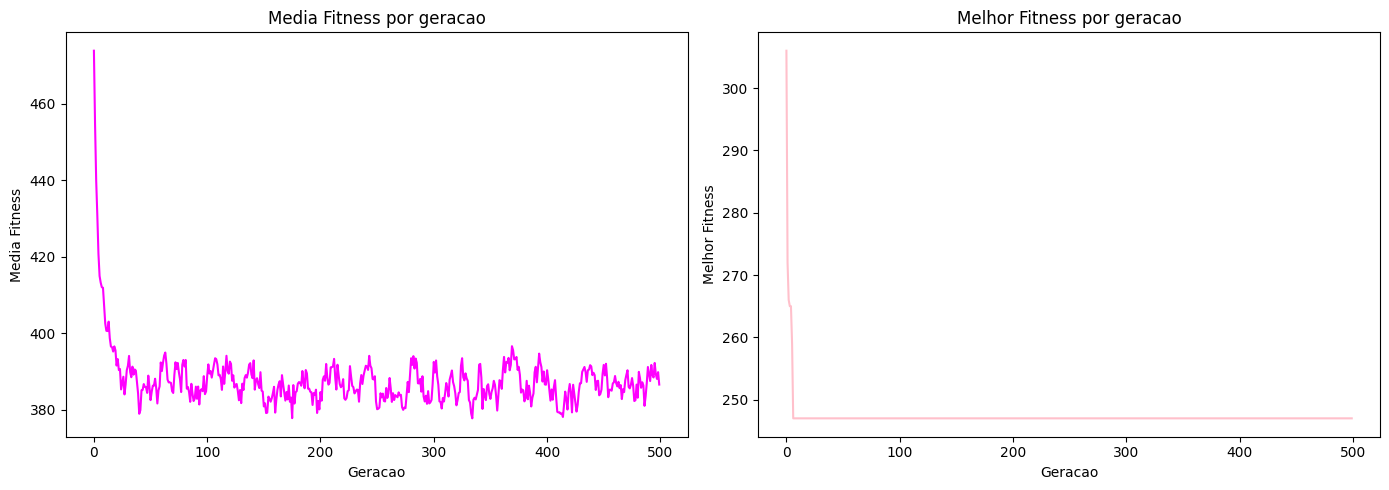


🏁 Resultados finais:
Menor média de fitness: 377.73 na geração 334
Melhor fitness individual: 247 na geração 6
Geração 0: Média = 473.88 | Melhor = 306
Geração 1: Média = 454.64 | Melhor = 272
Geração 2: Média = 439.91 | Melhor = 266
Geração 3: Média = 430.82 | Melhor = 265
Geração 4: Média = 420.74 | Melhor = 265
Geração 5: Média = 414.95 | Melhor = 259
Geração 6: Média = 413.21 | Melhor = 247
Geração 7: Média = 412.02 | Melhor = 247
Geração 8: Média = 411.89 | Melhor = 247
Geração 9: Média = 407.12 | Melhor = 247
Geração 10: Média = 402.52 | Melhor = 247
Geração 11: Média = 400.63 | Melhor = 247
Geração 12: Média = 400.56 | Melhor = 247
Geração 13: Média = 403.02 | Melhor = 247
Geração 14: Média = 398.69 | Melhor = 247
Geração 15: Média = 396.51 | Melhor = 247
Geração 16: Média = 396.35 | Melhor = 247
Geração 17: Média = 395.20 | Melhor = 247
Geração 18: Média = 396.56 | Melhor = 247
Geração 19: Média = 395.55 | Melhor = 247
Geração 20: Média = 391.54 | Melhor = 247
Geração 21: Médi

In [ ]:
mediaFitness = []
melhorFitness = []

for geracao in range(NUM_GENERATIONS):
    population = nova_geracao(population, dist_matrix, recombinacao, mutacao)

    custos = [individuo[1] for individuo in population]
    mediaFitness.append(np.mean(custos))
    melhorFitness.append(np.min(custos))

plotGraficos(mediaFitness, melhorFitness)

# Melhor média (menor valor médio)
melhor_media = min(mediaFitness)
geracao_melhor_media = mediaFitness.index(melhor_media)

# Melhor fitness absoluto (menor custo)
melhor_fitness = min(melhorFitness)
geracao_melhor_fitness = melhorFitness.index(melhor_fitness)

# Printar resultados
print("\n🏁 Resultados finais:")
print(f"Menor média de fitness: {melhor_media:.2f} na geração {geracao_melhor_media}")
print(f"Melhor fitness individual: {melhor_fitness} na geração {geracao_melhor_fitness}")


for i in range(NUM_GENERATIONS):
    print(f"Geração {i}: Média = {mediaFitness[i]:.2f} | Melhor = {melhorFitness[i]}")




## Algoritmos de Otimização

### Função base

In [ ]:
def grid_search(opt_func, dist_matrix, param_grid, fixed_args={}, n_runs=30, verbose=False):
    """
    Executa uma busca exaustiva nos hiperparâmetros com média sobre múltiplas execuções.
    Especificamente adaptado para o Problema do Caixeiro Viajante (TSP).

    Parâmetros:
    - opt_func: função do algoritmo de otimização (ex: pso)
    - dist_matrix: matriz numpy de distâncias entre as cidades
    - param_grid: dicionário com listas de hiperparâmetros a testar
    - fixed_args: dicionário com argumentos fixos para o algoritmo
    - n_runs: número de vezes que cada configuração será testada
    - verbose: se True, imprime o progresso

    Retorna:
    - melhor_score_medio: menor média de score obtida
    - melhor_params: dicionário com os hiperparâmetros ideais
    """

    # Converte para numpy array se não for
    if not isinstance(dist_matrix, np.ndarray):
        dist_matrix = np.array(dist_matrix)

    keys = list(param_grid.keys())
    values = list(param_grid.values())

    best_avg_score = float('inf')
    best_params = None

    total_combinations = len(list(product(*values)))
    count = 0

    for combo in product(*values):
        count += 1
        params = dict(zip(keys, combo))
        args = {**fixed_args, **params}

        scores = []
        for _ in range(n_runs):
            # Passa a função fitness e a matriz de distâncias para o algoritmo de otimização
            _, score, _ = opt_func(lambda individuo: fitness(individuo, dist_matrix), **args)
            scores.append(score)

        avg_score = np.mean(scores)
        std_score = np.std(scores)

        if verbose:
            print(f"[{count}/{total_combinations}] {params} -> média: {avg_score:.5f}, desvio: {std_score:.5f}")

        if avg_score < best_avg_score:
            best_avg_score = avg_score
            best_params = params

    return best_avg_score, best_params

### ❉ PSO

In [ ]:
def pso(fitness_func,
        num_particles=30,
        dimensions=30,
        iterations=100,
        bounds=(-5.12, 5.12),
        w=0.7, c1=1.5, c2=1.5,
        verbose=False
        ):

    # Inicialização
    positions = np.random.uniform(bounds[0], bounds[1], (num_particles, dimensions))
    velocities = np.zeros((num_particles, dimensions))

    pbest = positions.copy()
    pbest_scores = np.apply_along_axis(fitness_func, 1, pbest)

    gbest = pbest[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)

    history = [gbest_score]

    for it in range(iterations):
        r1 = np.random.rand(num_particles, dimensions)
        r2 = np.random.rand(num_particles, dimensions)

        velocities = (w * velocities
                      + c1 * r1 * (pbest - positions)
                      + c2 * r2 * (gbest - positions))

        positions += velocities
        positions = np.clip(positions, bounds[0], bounds[1])

        scores = np.apply_along_axis(fitness_func, 1, positions)

        # Atualiza pbest
        mask = scores < pbest_scores
        pbest[mask] = positions[mask]
        pbest_scores[mask] = scores[mask]

        # Atualiza gbest
        current_best_score = np.min(scores)
        if current_best_score < gbest_score:
            gbest = positions[np.argmin(scores)]
            gbest_score = current_best_score

        history.append(gbest_score)

        if verbose and (it % 10 == 0 or it == iterations - 1):
            print(f"Iteração {it+1}/{iterations} - Melhor: {gbest_score:.5f}")

    return gbest, gbest_score, history

In [ ]:
param_grid_pso = {
    'num_particles': [20, 30, 50],
    'iterations': [50, 100, 200]
}

fixed_args_pso = {
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

best_score_pso, best_params_pso = grid_search(pso, dist_matrix, param_grid_pso, fixed_args_pso, verbose=True)

print("\nPSO - Melhores hiperparâmetros encontrados:", best_params_pso)
print("PSO - Melhor valor da função:", best_score_pso)

[1/9] {'num_particles': 20, 'iterations': 50} -> média: 281.86667, desvio: 22.75922
[2/9] {'num_particles': 20, 'iterations': 100} -> média: 284.93333, desvio: 25.12228
[3/9] {'num_particles': 20, 'iterations': 200} -> média: 286.63333, desvio: 24.52683
[4/9] {'num_particles': 30, 'iterations': 50} -> média: 283.13333, desvio: 22.83234
[5/9] {'num_particles': 30, 'iterations': 100} -> média: 275.86667, desvio: 25.40569
[6/9] {'num_particles': 30, 'iterations': 200} -> média: 281.36667, desvio: 23.89907
[7/9] {'num_particles': 50, 'iterations': 50} -> média: 276.20000, desvio: 19.42404
[8/9] {'num_particles': 50, 'iterations': 100} -> média: 273.80000, desvio: 22.00818
[9/9] {'num_particles': 50, 'iterations': 200} -> média: 271.36667, desvio: 18.63953

PSO - Melhores hiperparâmetros encontrados: {'num_particles': 50, 'iterations': 200}
PSO - Melhor valor da função: 271.3666666666667


### 🪰 DA

In [ ]:
def da(fitness_func,
       num_agents=30,
       dimensions=30,
       iterations=100,
       bounds=(-5.12, 5.12),
       w=0.9, s=0.1, a=0.1, c=0.1, f=2.0, e=1.0,
       verbose=False
       ):

    # Inicialização de posições e velocidades
    positions = np.random.uniform(bounds[0], bounds[1], (num_agents, dimensions))
    velocities = np.zeros((num_agents, dimensions))

    def distance_matrix(positions):
        diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        dist = np.linalg.norm(diff, axis=2)
        return dist

    # Avaliação inicial
    fitness = np.apply_along_axis(fitness_func, 1, positions)
    food_idx = np.argmin(fitness)
    enemy_idx = np.argmax(fitness)
    food_pos = positions[food_idx].copy()
    enemy_pos = positions[enemy_idx].copy()
    food_score = fitness[food_idx]
    enemy_score = fitness[enemy_idx]

    history = [food_score]

    for iter in range(iterations):
        dist = distance_matrix(positions)
        np.fill_diagonal(dist, np.inf)

        for i in range(num_agents):
            neighbors = np.where(dist[i] < (bounds[1] - bounds[0]) / 10)[0]

            if len(neighbors) > 0:
                S = -np.sum(positions[neighbors] - positions[i], axis=0)
                A_ = np.mean(velocities[neighbors], axis=0)
                center = np.mean(positions[neighbors], axis=0)
                C = center - positions[i]
            else:
                S = np.zeros(dimensions)
                A_ = np.zeros(dimensions)
                C = np.zeros(dimensions)

            F = food_pos - positions[i]
            E = enemy_pos + positions[i]

            velocities[i] = (w * velocities[i]
                             + s * S
                             + a * A_
                             + c * C
                             + f * F
                             - e * E)

            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], bounds[0], bounds[1])

        fitness = np.apply_along_axis(fitness_func, 1, positions)

        current_food_idx = np.argmin(fitness)
        current_food_score = fitness[current_food_idx]
        if current_food_score < food_score:
            food_score = current_food_score
            food_pos = positions[current_food_idx].copy()

        current_enemy_idx = np.argmax(fitness)
        current_enemy_score = fitness[current_enemy_idx]
        if current_enemy_score > enemy_score:
            enemy_score = current_enemy_score
            enemy_pos = positions[current_enemy_idx].copy()

        history.append(food_score)

        if verbose and (iter % 10 == 0 or iter == iterations - 1):
            print(f"Iteração {iter+1}/{iterations} - Melhor: {food_score:.5f}")

    return food_pos, food_score, history

In [ ]:
param_grid_da = {
    'w': [0.7, 0.9],
    's': [0.05, 0.1],
    'a': [0.05, 0.1],
    'c': [0.05, 0.1],
    'f': [1.0, 2.0],
    'e': [0.5, 1.0]
}

fixed_args_da = {
    'num_agents': 30,
    'iterations': 100,
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

best_score_da, best_params_da = grid_search(da, dist_matrix, param_grid_da, fixed_args_da, n_runs=30, verbose=True)

print("\nDA - Melhores parâmetros encontrados:", best_params_da)
print("DA - Melhor valor médio da função:", best_score_da)

[1/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.05, 'f': 1.0, 'e': 0.5} -> média: 348.93333, desvio: 30.63107
[2/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.05, 'f': 1.0, 'e': 1.0} -> média: 351.63333, desvio: 37.57613
[3/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.05, 'f': 2.0, 'e': 0.5} -> média: 334.93333, desvio: 36.98733
[4/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.05, 'f': 2.0, 'e': 1.0} -> média: 347.73333, desvio: 30.45208
[5/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.1, 'f': 1.0, 'e': 0.5} -> média: 334.06667, desvio: 33.11790
[6/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.1, 'f': 1.0, 'e': 1.0} -> média: 362.66667, desvio: 33.34300
[7/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.1, 'f': 2.0, 'e': 0.5} -> média: 335.76667, desvio: 32.71461
[8/64] {'w': 0.7, 's': 0.05, 'a': 0.05, 'c': 0.1, 'f': 2.0, 'e': 1.0} -> média: 337.80000, desvio: 35.60000
[9/64] {'w': 0.7, 's': 0.05, 'a': 0.1, 'c': 0.05, 'f': 1.0, 'e': 0.5} -> média: 348.30000, desvio: 28.83880
[10/64] {'w': 0.7, 's': 

### 🐜 ACO

In [ ]:
def aco(
    fitness_func,
    num_ants=30,
    dimensions=30,
    bounds=(-5.12, 5.12),
    iterations=100,
    archive_size=30,
    q=0.5,
    xi=0.85,
    verbose=False
):

    # Inicializa archive aleatório
    archive_positions = np.random.uniform(bounds[0], bounds[1], (archive_size, dimensions))
    archive_scores = np.apply_along_axis(fitness_func, 1, archive_positions)

    history = [np.min(archive_scores)]

    for iter in range(iterations):
        # Ordena o archive pelas melhores soluções
        idx_sorted = np.argsort(archive_scores)
        archive_positions = archive_positions[idx_sorted]
        archive_scores = archive_scores[idx_sorted]

        # Calcula pesos decrescentes para as soluções melhores
        weights = np.array([q * (1 - q) ** i for i in range(archive_size)])
        weights /= np.sum(weights)

        new_ants = np.zeros((num_ants, dimensions))

        for k in range(num_ants):
            new_solution = np.zeros(dimensions)
            for d in range(dimensions):
                # Média ponderada para a dimensão d
                mean_d = np.sum(weights * archive_positions[:, d])
                # Desvio padrão ponderado
                sigma_d = np.sqrt(np.sum(weights * (archive_positions[:, d] - mean_d) ** 2)) + 1e-10

                # Amostra normal para gerar novo valor na dimensão d
                new_solution[d] = np.random.normal(mean_d, xi * sigma_d)

            # Limita dentro dos bounds
            new_solution = np.clip(new_solution, bounds[0], bounds[1])
            new_ants[k] = new_solution

        # Avalia novas soluções
        new_scores = np.apply_along_axis(fitness_func, 1, new_ants)

        # Atualiza archive juntando e escolhendo as melhores soluções
        combined_positions = np.vstack((archive_positions, new_ants))
        combined_scores = np.hstack((archive_scores, new_scores))

        idx_sorted = np.argsort(combined_scores)
        archive_positions = combined_positions[idx_sorted][:archive_size]
        archive_scores = combined_scores[idx_sorted][:archive_size]

        history.append(archive_scores[0])

        if verbose and (iter % 10 == 0 or iter == iterations - 1):
            print(f"Iteração {iter+1}/{iterations} - Melhor score: {archive_scores[0]}")

    best_position = archive_positions[0]
    best_score = archive_scores[0]

    return best_position, best_score, history

In [ ]:
param_grid_aco = {
    'q': [0.2, 0.35, 0.5, 0.65, 0.8],
    'xi': [0.5, 0.65, 0.8, 0.95, 1.1]
}

fixed_args_aco = {
    'num_ants': 30,
    'archive_size': 30,
    'iterations': 100,
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

best_score_aco, best_params_aco = grid_search(aco, dist_matrix, param_grid_aco, fixed_args_aco, n_runs=30, verbose=True)

print("\nACO - Melhores parâmetros encontrados:", best_params_aco)
print("ACO - Melhor valor médio da função:", best_score_aco)

[1/25] {'q': 0.2, 'xi': 0.5} -> média: 303.20000, desvio: 24.36035
[2/25] {'q': 0.2, 'xi': 0.65} -> média: 291.13333, desvio: 21.91306
[3/25] {'q': 0.2, 'xi': 0.8} -> média: 282.00000, desvio: 21.51434
[4/25] {'q': 0.2, 'xi': 0.95} -> média: 277.26667, desvio: 16.65319
[5/25] {'q': 0.2, 'xi': 1.1} -> média: 265.13333, desvio: 13.62530
[6/25] {'q': 0.35, 'xi': 0.5} -> média: 306.50000, desvio: 26.73044
[7/25] {'q': 0.35, 'xi': 0.65} -> média: 298.10000, desvio: 24.45452
[8/25] {'q': 0.35, 'xi': 0.8} -> média: 299.43333, desvio: 28.13027
[9/25] {'q': 0.35, 'xi': 0.95} -> média: 278.26667, desvio: 20.50518
[10/25] {'q': 0.35, 'xi': 1.1} -> média: 280.46667, desvio: 21.63906
[11/25] {'q': 0.5, 'xi': 0.5} -> média: 335.10000, desvio: 28.22924
[12/25] {'q': 0.5, 'xi': 0.65} -> média: 313.86667, desvio: 21.83382
[13/25] {'q': 0.5, 'xi': 0.8} -> média: 308.76667, desvio: 25.08344
[14/25] {'q': 0.5, 'xi': 0.95} -> média: 296.33333, desvio: 27.42181
[15/25] {'q': 0.5, 'xi': 1.1} -> média: 289.80

### 🐾 ES (μ, λ)

In [ ]:
def es(fitness_func,
       mu=15,
       sigma=0.1,
       dimensions=30,
       bounds=(-5.12, 5.12),
       generations=100,
       verbose=False):

    lambd = 5 * mu  # população de filhos

    # Inicializa população parental
    parents = np.random.uniform(bounds[0], bounds[1], (mu, dimensions))
    parents_fitness = np.apply_along_axis(fitness_func, 1, parents)

    history = [np.min(parents_fitness)]

    for gen in range(generations):
        # Gera λ filhos por mutação gaussiana dos pais selecionados
        offspring = np.zeros((lambd, dimensions))
        for i in range(lambd):
            # seleciona aleatoriamente um pai
            parent_idx = np.random.randint(mu)
            # mutação gaussiana
            child = parents[parent_idx] + np.random.normal(0, sigma, dimensions)
            # garante limites
            child = np.clip(child, bounds[0], bounds[1])
            offspring[i] = child

        offspring_fitness = np.apply_along_axis(fitness_func, 1, offspring)

        # Seleção truncada: junta pais e filhos e escolhe os melhores μ
        combined = np.vstack((parents, offspring))
        combined_fitness = np.hstack((parents_fitness, offspring_fitness))

        idx_sorted = np.argsort(combined_fitness)
        parents = combined[idx_sorted][:mu]
        parents_fitness = combined_fitness[idx_sorted][:mu]

        best_fit = parents_fitness[0]
        history.append(best_fit)

        if verbose and (gen % 10 == 0 or gen == generations - 1):
            print(f"Geração {gen+1}/{generations} - Melhor fitness: {best_fit:.5f}")

    best_solucao = parents[0]
    melhor_fitness = parents_fitness[0]

    return best_solucao, melhor_fitness, history

In [ ]:
param_grid_es = {
    'mu': [15, 20, 30],
    'sigma': [0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.95]
}

fixed_args_es = {
    'generations': 100,
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

best_score_es, best_params_es = grid_search(es, dist_matrix, param_grid_es, fixed_args_es, n_runs=30, verbose=True)

print("\nES - Melhores parâmetros encontrados:", best_params_es)
print("ES - Melhor valor médio da função:", best_score_es)

[1/21] {'mu': 15, 'sigma': 0.05} -> média: 362.03333, desvio: 36.94364
[2/21] {'mu': 15, 'sigma': 0.1} -> média: 340.43333, desvio: 36.69304
[3/21] {'mu': 15, 'sigma': 0.2} -> média: 304.40000, desvio: 25.80129
[4/21] {'mu': 15, 'sigma': 0.3} -> média: 291.66667, desvio: 25.54517
[5/21] {'mu': 15, 'sigma': 0.5} -> média: 274.46667, desvio: 19.08007
[6/21] {'mu': 15, 'sigma': 0.8} -> média: 263.26667, desvio: 13.27638
[7/21] {'mu': 15, 'sigma': 0.95} -> média: 260.20000, desvio: 10.82713
[8/21] {'mu': 20, 'sigma': 0.05} -> média: 369.63333, desvio: 27.60735
[9/21] {'mu': 20, 'sigma': 0.1} -> média: 326.33333, desvio: 37.26869
[10/21] {'mu': 20, 'sigma': 0.2} -> média: 303.00000, desvio: 29.67827
[11/21] {'mu': 20, 'sigma': 0.3} -> média: 283.03333, desvio: 21.13368
[12/21] {'mu': 20, 'sigma': 0.5} -> média: 268.00000, desvio: 16.55899
[13/21] {'mu': 20, 'sigma': 0.8} -> média: 259.93333, desvio: 10.54177
[14/21] {'mu': 20, 'sigma': 0.95} -> média: 255.80000, desvio: 10.08762
[15/21] {'m

## 🧪 Análise

### PSO com os melhores hiperparâmetros

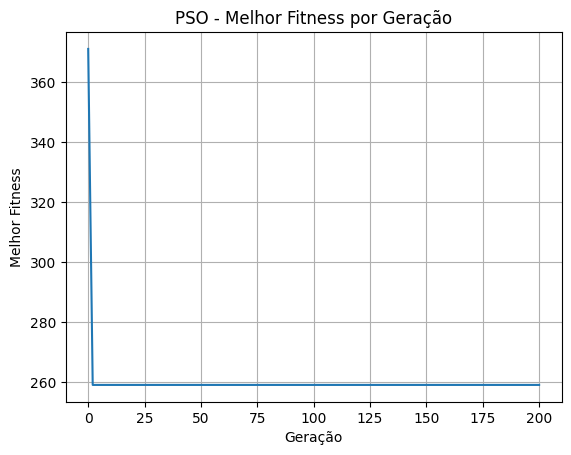

Fitness final (melhor): 259


In [ ]:
# Executa PSO com os melhores hiperparâmetros encontrados
best_params_pso = {'num_particles': 50, 'iterations': 200}
fixed_args_pso = {
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

# Roda o PSO e armazena o histórico de fitness
gbest, gbest_score, history_pso = pso(
    lambda ind: fitness(ind, dist_matrix),
    **best_params_pso,
    **fixed_args_pso
)

# Calcula a média de fitness por geração (histórico já é o melhor fitness de cada geração)
import matplotlib.pyplot as plt

plt.plot(history_pso)
plt.title("PSO - Melhor Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.grid(True)
plt.show()

print("Fitness final (melhor):", gbest_score)


### DA com os melhores hiperparâmetros

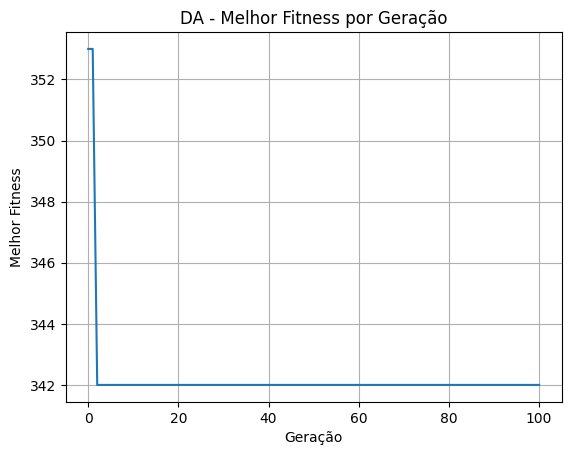

Fitness final (melhor): 342


In [ ]:
# Executa DA com os melhores hiperparâmetros encontrados
best_params_da = {'w': 0.9, 's': 0.05, 'a': 0.05, 'c': 0.1, 'f': 2.0, 'e': 0.5}
fixed_args_da = {
    'num_agents': 30,         # Número de agentes/vaga-lumes
    'iterations': 100,        # Número de iterações
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

# Roda o DA e armazena o histórico de fitness
food_pos, food_score, history_da = da(
    lambda ind: fitness(ind, dist_matrix),
    **best_params_da,
    **fixed_args_da
)

# Plota o melhor fitness por geração
import matplotlib.pyplot as plt

plt.plot(history_da)
plt.title("DA - Melhor Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.grid(True)
plt.show()

print("Fitness final (melhor):", food_score)

### ACO com os melhores hiperparâmetros

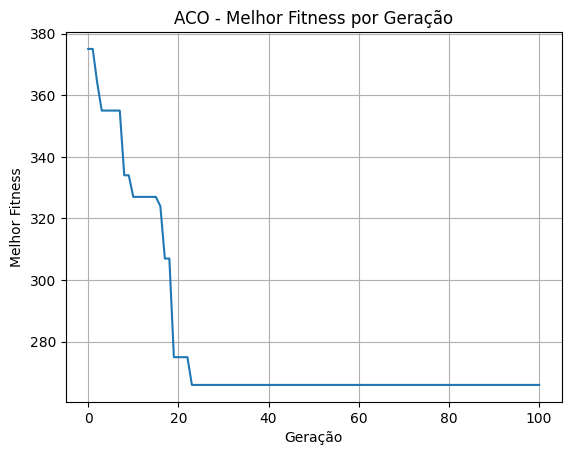

Fitness final (melhor): 266


In [ ]:
# Executa ACO com os melhores hiperparâmetros encontrados
best_params_aco = {'q': 0.2, 'xi': 1.1}
fixed_args_aco = {
    'num_ants': 30,           # Número de formigas
    'archive_size': 30,       # Tamanho do arquivo de soluções
    'iterations': 100,        # Número de iterações
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

# Roda o ACO e armazena o histórico de fitness
best_position, best_score, history_aco = aco(
    lambda ind: fitness(ind, dist_matrix),
    **best_params_aco,
    **fixed_args_aco
)

# Plota o melhor fitness por geração
import matplotlib.pyplot as plt

plt.plot(history_aco)
plt.title("ACO - Melhor Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.grid(True)
plt.show()

print("Fitness final (melhor):", best_score)

### GA com os melhores hiperparâmetros

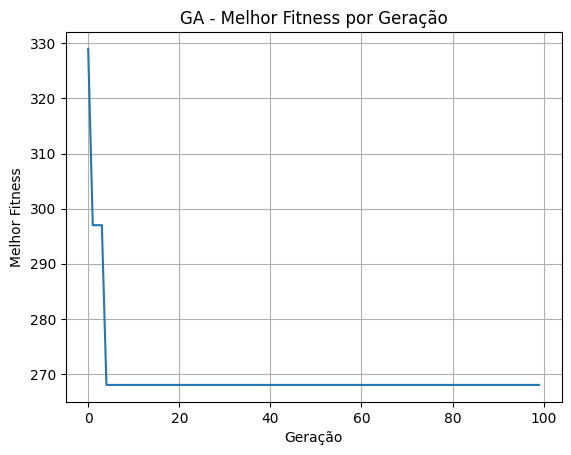

Fitness final (melhor): 268


In [ ]:
# Executa GA com os melhores hiperparâmetros encontrados
best_params_ga = {'mutation_rate': 0.6, 'crossover_rate': 0.5, 'elitism': 2, 'tournament_k': 3}
fixed_args_ga = {
    'pop_size': 100,          # Tamanho da população
    'generations': 100,       # Número de gerações
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

# Roda o GA e armazena o histórico de fitness
best_solution, best_score, (history_best, history_mean) = ga(
    lambda ind: fitness(ind, dist_matrix),
    **best_params_ga,
    **fixed_args_ga
)

# Plota o melhor fitness por geração
import matplotlib.pyplot as plt

plt.plot(history_best)
plt.title("GA - Melhor Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.grid(True)
plt.show()

print("Fitness final (melhor):", best_score)

### ES com os melhores hiperparâmetros

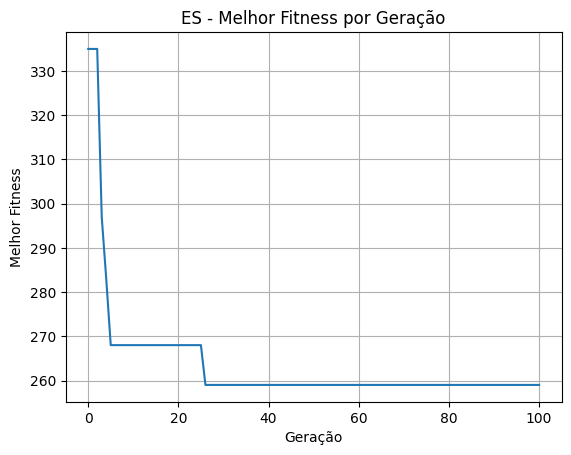

Fitness final (melhor): 259


In [ ]:
# Executa ES com os melhores hiperparâmetros encontrados
best_params_es = {'mu': 30, 'sigma': 0.95}
fixed_args_es = {
    'generations': 100,       # Número de gerações
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix)-1),
    'verbose': False
}

# Roda o ES e armazena o histórico de fitness
best_solucao, melhor_fitness, history_es = es(
    lambda ind: fitness(ind, dist_matrix),
    **best_params_es,
    **fixed_args_es
)

# Plota o melhor fitness por geração
import matplotlib.pyplot as plt

plt.plot(history_es)
plt.title("ES - Melhor Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.grid(True)
plt.show()

print("Fitness final (melhor):", melhor_fitness)

### Comparando as 5 soluções

Iniciando execuções para comparação...
Executando PSO...
Executando DA...
Executando ACO...
Executando GA...
Executando ES...
Execuções concluídas. Gerando gráfico...


/tmp/ipython-input-591329432.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_results, labels=labels)


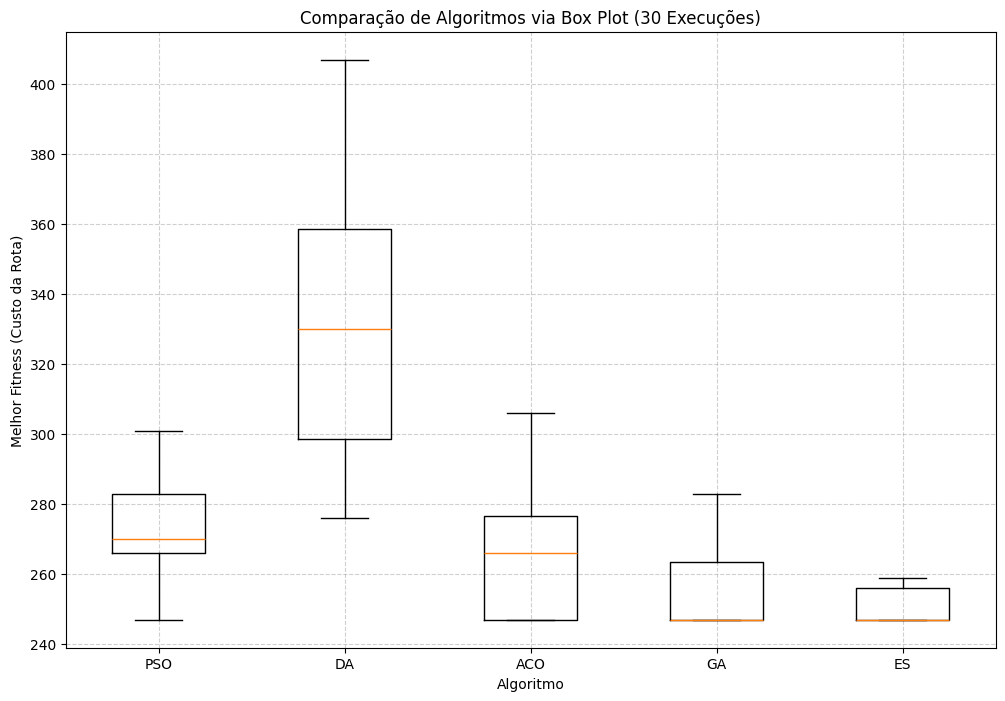

Gráfico 'comparacao_algoritmos_boxplot.png' foi salvo.


In [ ]:
# Hiperparâmetros otimizados para cada algoritmo
params = {
    'PSO': {'num_particles': 50, 'iterations': 200},
    'DA': {'w': 0.9, 's': 0.05, 'a': 0.05, 'c': 0.1, 'f': 2.0, 'e': 0.5},
    'ACO': {'q': 0.2, 'xi': 1.1},
    'GA': {'mutation_rate': 0.6, 'crossover_rate': 0.5, 'elitism': 2, 'tournament_k': 3},
    'ES': {'mu': 30, 'sigma': 0.95}
}

# Argumentos fixos
fixed_args = {
    'dimensions': len(dist_matrix),
    'bounds': (0, len(dist_matrix) - 1),
    'verbose': False
}

# Dicionário de funções de algoritmos
algorithms = {
    'PSO': pso,
    'DA': da,
    'ACO': aco,
    'GA': ga,
    'ES': es
}

n_runs = 30
all_results = []
labels = list(algorithms.keys())

print("Iniciando execuções para comparação...")

for name, func in algorithms.items():
    print(f"Executando {name}...")
    # Argumentos específicos para GA e ES
    if name == 'GA':
        current_fixed = {**fixed_args, 'pop_size': 100, 'generations': 100}
    elif name == 'ES':
        current_fixed = {**fixed_args, 'generations': 100}
    else:
        current_fixed = fixed_args.copy()

    current_params = {**params[name], **current_fixed}
    scores = []
    for i in range(n_runs):
        _, best_score, _ = func(lambda ind: fitness(ind, dist_matrix), **current_params)
        scores.append(best_score)
    all_results.append(scores)

print("Execuções concluídas. Gerando gráfico...")

# Criando o Box Plot
plt.figure(figsize=(12, 8))
plt.boxplot(all_results, labels=labels)
plt.title('Comparação de Algoritmos via Box Plot (30 Execuções)')
plt.ylabel('Melhor Fitness (Custo da Rota)')
plt.xlabel('Algoritmo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('comparacao_algoritmos_boxplot.png')
plt.show()
plt.close()

print("Gráfico 'comparacao_algoritmos_boxplot.png' foi salvo.")